## 1. Required libraries

In [1]:
!pip install rasterio
!pip install albumentations
!pip install segmentation_models_pytorch
!pip install torchmetrics

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import math

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import albumentations as A

import segmentation_models_pytorch as smp

import torchmetrics as tm

import rasterio as rio
from rasterio.plot import show

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=b373faabca65309def2d93f12f4441102f1fccc1404ddacdc1368a4033b80b9c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=fa537d3927b5ffa08e793538daa167b3a4ce6b853ea019a

## 2. Global variables | Directories

In [87]:
# Data localization
DATA_CHIPS = '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/'
SPLITTED_DATA = '/content/splitted'
MODELS = '/content/models'
RESULTS = '/content/results'
PREDICTED_MASKS = '/content/predictions'

# Model parameters
ENCODER = "resnet18"
ENCODER_WEIGHTS = None
ACTIVATION = None

In [88]:
# Directories preparation

os.makedirs(SPLITTED_DATA, exist_ok = True)
os.makedirs(MODELS, exist_ok = True)
os.makedirs(RESULTS, exist_ok = True)
os.makedirs(PREDICTED_MASKS, exist_ok = True)

## 3. Setting up device (GPU if ready)

In [89]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


## 4. Data preparation (image chips - 256x256 | Stride 128x128 generated with QGIS)

In [90]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r

In [91]:
all_files = list_files(DATA_CHIPS)
image_list = [file for file in all_files if ('Feature' in file)]
mask_list = [file for file in all_files if ('Mask' in file)]

image_list = sorted(image_list)
mask_list = sorted(mask_list)

print(image_list[:5], mask_list[:5])

['/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Feature1_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Feature2_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Feature3_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Feature4_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2017/Feature1_1.tif'] ['/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Mask1_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Mask2_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Mask3_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2016/Mask4_1.tif', '/content/drive/MyDrive/GIS_ML/test_dataset/Chips/Albania1/2017/Mask1_1.tif']


In [92]:
df = pd.DataFrame(list(zip(image_list, mask_list)),
                  columns=['image_path','mask_path'])

In [93]:
df.head()

,image_path,mask_path
0,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...
1,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...
2,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...
3,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...
4,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...,/content/drive/MyDrive/GIS_ML/test_dataset/Chi...


In [94]:
positive_chips = []
negative_chips = []

for mask in mask_list:
  mask_source = rio.open(mask)
  mask_array = mask_source.read()
  mask_source.close()

  if mask_array.sum() == 0:
    positive_chips.append(mask)
  else:
    negative_chips.append(mask)

In [95]:
def describe(column):
  if column in positive_chips:
    return 'mine positive'
  else:
    return 'background'

df['contains'] = df.apply(lambda row: describe(row['mask_path']), axis=1)

In [96]:
train = df.sample(frac=0.7,random_state=101)
leftovers = df.drop(train.index)
test = leftovers.sample(frac=0.5,random_state=101)
val = leftovers.drop(test.index)

In [97]:
train.to_csv(SPLITTED_DATA+'/mytrain.csv', index=False)
test.to_csv(SPLITTED_DATA+'/mytest.csv', index=False)
val.to_csv(SPLITTED_DATA+'/myval.csv', index=False)

In [98]:
train = pd.read_csv(SPLITTED_DATA+'/mytrain.csv')
test = pd.read_csv(SPLITTED_DATA+'/mytest.csv')
val = pd.read_csv(SPLITTED_DATA+'/myval.csv')

In [99]:
positive_mine_number = train.groupby(['contains'])['contains'].count()[1]

sample = int(positive_mine_number * 2)

In [100]:
train_positive = train.query('contains == "mine positive"')
train_background = train.query("contains == 'background'")
train_background = train_background.sample(n=sample, replace=False)
train = pd.concat([train_positive, train_background])

In [101]:
train.groupby(['contains'])['contains'].count()

contains
background       34
mine positive    17
Name: contains, dtype: int64

In [102]:
class AlbaniaDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        image_name = self.df.iloc[index, 0]
        mask_name = self.df.iloc[index, 1]
        image_source = rio.open(image_name)
        image = image_source.read()
        image_source.close
        image = image[[1,2,3,4,5,6,7,8,9,10,11,12],:,:]
        mask_source = rio.open(mask_name)
        mask = mask_source.read()
        mask_source.close()
        image = image.astype('float32')
        mask = mask.astype('float32')

        if(self.transform is not None):
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            image = torch.from_numpy(image.copy())
            mask = torch.from_numpy(mask.copy())
            image = image.float()/255 # Data normalization (between 0-1)
            mask = mask.float()
            mask = mask.squeeze().long()
        else:
            image = torch.from_numpy(image.copy())
            mask = torch.from_numpy(mask.copy())
            image = image.float()/255 # Data normalization (between 0-1)
            mask = mask.float()
            mask = mask.squeeze().long()
        return image, mask
    def __len__(self):
        return len(self.df)

In [103]:
# Additional transformation to minimalize memorizing pixels by model

train_transform = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.MedianBlur(blur_limit=3, always_apply=False, p=0.1),
    ]
)

In [104]:
train_dataset = AlbaniaDataset(train, transform=train_transform)
validation_dataset = AlbaniaDataset(val, transform=None)

print('Number of Training Samples: ' + str(len(train_dataset)) + ' Number of Validation Samples: ' + str(len(validation_dataset)))

Number of Training Samples: 51 Number of Validation Samples: 17


In [105]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=0, drop_last=True)

## 5. Model preparation

In [106]:
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=2,
    activation=ACTIVATION,
)

model.encoder.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False) # Changing first layer to get all bands as an input
model = model.to(device)

print(next(model.parameters()).is_cuda)

True


In [107]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [108]:
#https://github.com/qubvel/segmentation_models.pytorch/issues/79
def freeze_encoder(model):
    for child in model.encoder.children():
        for param in child.parameters():
            param.requires_grad = False
    return

def unfreeze(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True
    return

## 6. Model training

In [109]:
acc = tm.Accuracy(task='multiclass', average='macro', num_classes=2).to(device)
f1 = tm.F1Score(task='multiclass', average='macro', num_classes=2).to(device)
kappa = tm.CohenKappa(task='multiclass', average='macro', num_classes=2).to(device)

In [110]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):

  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Get data and move to device
    inputs, targets = inputs.to(device), targets.to(device)

    # Clear gradients
    optimizer.zero_grad()
    # Predict data
    outputs = model(inputs)
    # Calculate loss
    loss = loss_fn(outputs, targets)

    # Calculate metrics
    accuracy_train = acc(outputs, targets)
    f1_score_train = f1(outputs, targets)
    kappa_train = kappa(outputs, targets)

    # Backpropagate
    loss.backward()

    # Update parameters
    optimizer.step()

  # Accumulate metrics at end of training epoch
  accuracy_train = acc.compute()
  f1_score_train = f1.compute()
  kappa_train = kappa.compute()

  # Print Losses and metrics at end of each training epoch
  print(f'Epoch: {epoch}, Training Loss: {loss.item():.4f}, Training Accuracy: {accuracy_train:.4f}, Training F1: {f1_score_train:.4f}, Training Kappa: {kappa_train:.4f}')

  # Append results
  epoch_number.append(epoch)
  train_loss.append(loss.item())
  train_acc.append(accuracy_train.detach().cpu().numpy())
  train_f1.append(f1_score_train.detach().cpu().numpy())
  train_kappa.append(kappa_train.detach().cpu().numpy())

  # Reset metrics
  acc.reset()
  f1.reset()
  kappa.reset()

In [111]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              f1_val_max_score: float,
              device: torch.device = device,
              ):

  f1_validation_max_score = f1_val_max_score

  model.eval()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Get data and move to device
      inputs, targets = inputs.to(device), targets.to(device)

      # Predict data
      outputs = model(inputs)
      # Calculate validation loss
      loss_validation = loss_fn(outputs, targets)

      # Calculate metrics
      accuracy_validation = acc(outputs, targets)
      f1_score_validation = f1(outputs, targets)
      kappa_validation = kappa(outputs, targets)

  # Accumulate metrics at end of validation epoch
  accuracy_validation = acc.compute()
  f1_score_validation = f1.compute()
  kappa_validation = kappa.compute()

  # Print validation loss and metrics
  print(f'Validation Loss: {loss_validation.item():.4f}, Validation Accuracy: {accuracy_validation:.4f}, Validation F1: {f1_score_validation:.4f}, Validation Kappa: {kappa_validation:.4f}')

  # Append results
  validation_loss.append(loss_validation.item())
  validation_acc.append(accuracy_validation.detach().cpu().numpy())
  validation_f1.append(f1_score_validation.detach().cpu().numpy())
  validation_kappa.append(kappa_validation.detach().cpu().numpy())

  # Reset metrics
  acc.reset()
  f1.reset()
  kappa.reset()

    # Save model if validation F1-score improves
  new_f1_validation = f1_score_validation.detach().cpu().numpy()
  if new_f1_validation > f1_validation_max_score:
      f1_validation_max_score = new_f1_validation
      torch.save(model.state_dict(), MODELS + '/albania_model_dlv3p.pt')
      print(f'Model saved for epoch {epoch}.')

  return f1_validation_max_score

In [112]:
epoch_number = []
train_loss = []
train_acc = []
train_f1 = []
train_kappa = []
validation_loss = []
validation_acc = []
validation_f1 = []
validation_kappa = []

EPOCHS = 250

f1_validation_max_score = 0.0

# Loop over epochs
for epoch in range(1, EPOCHS+1):
  train_step(model = model,
              data_loader = train_dataloader,
              loss_fn = criterion,
              optimizer = optimizer
              )

  f1_validation_max_score = test_step(model = model,
            data_loader = validation_dataloader,
            loss_fn = criterion,
            f1_val_max_score = f1_validation_max_score
              )

Epoch: 1, Training Loss: 0.4729, Training Accuracy: 0.6142, Training F1: 0.5493, Training Kappa: 0.1177
Validation Loss: 0.6338, Validation Accuracy: 0.6094, Validation F1: 0.6481, Validation Kappa: 0.2975
Model saved for epoch 1.
Epoch: 2, Training Loss: 0.5557, Training Accuracy: 0.5101, Training F1: 0.5089, Training Kappa: 0.0374
Validation Loss: 0.3026, Validation Accuracy: 0.5000, Validation F1: 0.4954, Validation Kappa: 0.0000
Epoch: 3, Training Loss: 0.2081, Training Accuracy: 0.5000, Training F1: 0.4885, Training Kappa: 0.0000
Validation Loss: 0.1311, Validation Accuracy: 0.5000, Validation F1: 0.4954, Validation Kappa: 0.0000
Epoch: 4, Training Loss: 0.4002, Training Accuracy: 0.5000, Training F1: 0.4885, Training Kappa: 0.0000
Validation Loss: 0.2292, Validation Accuracy: 0.5000, Validation F1: 0.4954, Validation Kappa: 0.0000
Epoch: 5, Training Loss: 0.4126, Training Accuracy: 0.5000, Training F1: 0.4886, Training Kappa: 0.0000
Validation Loss: 0.1421, Validation Accuracy: 0

In [113]:
epoch_series = pd.Series(epoch_number, name='epoch')
train_loss_series = pd.Series(train_loss, name='training_loss')
train_acc_series = pd.Series(train_acc, name='training_accuracy')
train_f1_series = pd.Series(train_f1, name='training_f1')
train_kappa_series = pd.Series(train_kappa, name='training_kappa')
validation_loss_series = pd.Series(validation_loss, name='val_loss')
validation_acc_series = pd.Series(validation_acc, name='val_accuracy')
validation_f1_series = pd.Series(validation_f1, name='val_f1')
validation_kappa_series = pd.Series(validation_kappa, name='val_kappa')

results_df = pd.concat([epoch_series,
                        train_loss_series,
                        train_acc_series,
                        train_f1_series,
                        train_kappa_series,
                        validation_loss_series,
                        validation_acc_series,
                        validation_f1_series,
                        validation_kappa_series],
                        axis=1)

In [114]:
results_df.to_csv(RESULTS+'/training_results_albania_model_dlv3p.csv')

In [115]:
results_df = pd.read_csv(RESULTS+'/training_results_albania_model_dlv3p.csv')

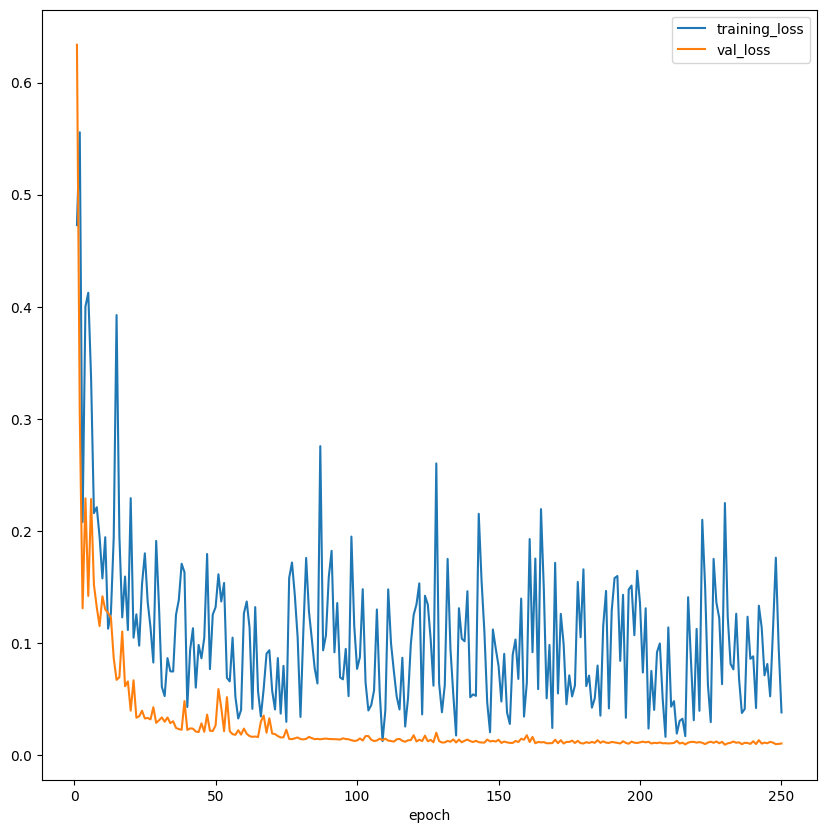

In [116]:
plt.rcParams['figure.figsize'] = [10, 10]
axis1 = results_df.plot(x='epoch', y='training_loss')
results_df.plot(x='epoch', y='val_loss', ax=axis1)
plt.show()

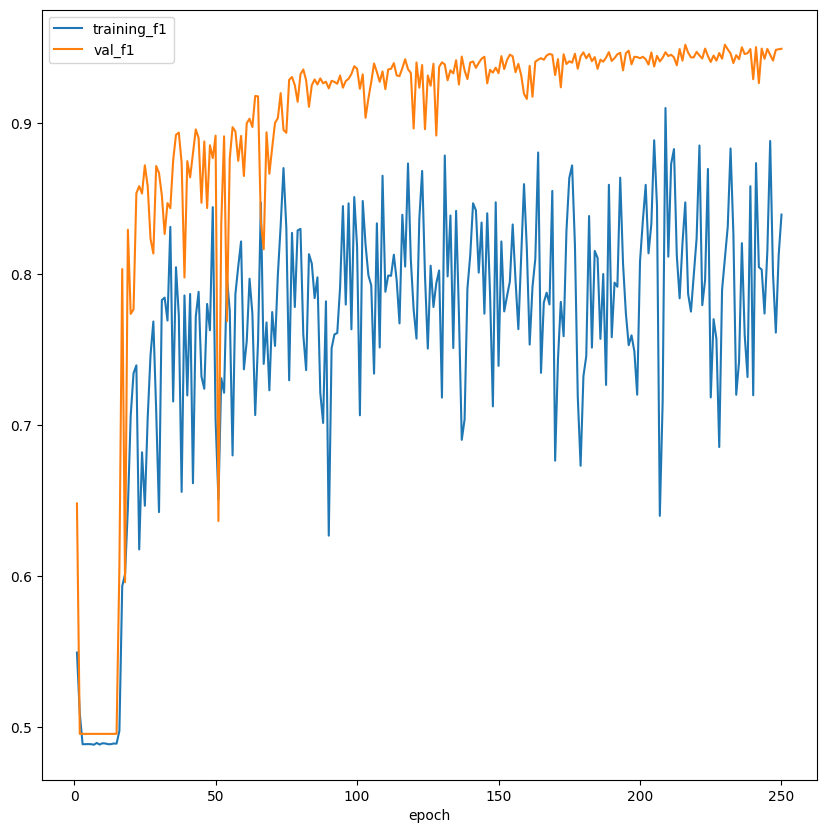

In [117]:
plt.rcParams['figure.figsize'] = [10, 10]
axis1 = results_df.plot(x='epoch', y='training_f1')
results_df.plot(x='epoch', y="val_f1", ax=axis1)
plt.show()

## 7. Testing model on unseen data

In [118]:
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=2,
    activation=ACTIVATION,
)

model.encoder.conv1 = nn.Conv2d(12, 64, kernel_size=7, stride=2, padding=3, bias=False) # Changing first layer to get all bands as an input
model = model.to(device)

print(next(model.parameters()).is_cuda)

True


In [119]:
model.load_state_dict(torch.load(MODELS + '/albania_model_dlv3p.pt'))

<All keys matched successfully>

In [120]:
test_dataset = AlbaniaDataset(test, transform=None)

In [121]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=0, drop_last=True)

In [122]:
acc = tm.Accuracy(task="multiclass", num_classes=2).to(device)
f1 = tm.F1Score(task="multiclass", num_classes=2, average='none').to(device)
recall = tm.Recall(task="multiclass", num_classes=2, average='none').to(device)
precision = tm.Precision(task="multiclass", num_classes=2, average='none').to(device)
kappa = tm.CohenKappa(task="multiclass", num_classes=2).to(device)
cm = tm.ConfusionMatrix(task="multiclass", num_classes=2).to(device)

In [123]:
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        prediction_accuracy = acc(outputs, targets)
        prediction_f1_score = f1(outputs, targets)
        prediction_recall = recall(outputs, targets)
        prediction_precision = precision(outputs, targets)
        prediction_kappa = kappa(outputs, targets)
        prediction_cm = cm(outputs, targets)

prediction_accuracy = acc.compute()
prediction_f1_score = f1.compute()
prediction_recall = recall.compute()
prediction_precision = precision.compute()
prediction_kappa = kappa.compute()
prediction_cm = cm.compute()
acc.reset()
f1.reset()
recall.reset()
precision.reset()
kappa.reset()
cm.reset()

In [124]:
print(f'Predicted mask statistics: Accuracy: {prediction_accuracy}\n F1_score: {prediction_f1_score}\n Recall:{prediction_recall}\n Precision: {prediction_precision}\n Kappa: {prediction_kappa}\n Confusion_matrix:\n {prediction_cm}')

Predicted mask statistics: Accuracy: 0.7166452407836914
 F1_score: tensor([0.8268, 0.2209], device='cuda:0')
 Recall:tensor([0.7080, 0.9020], device='cuda:0')
 Precision: tensor([0.9936, 0.1258], device='cuda:0')
 Kappa: 0.15481054782867432
 Confusion_matrix:
 tensor([[709345, 292542],
        [  4577,  42112]], device='cuda:0')


## 8. Predicted mask generation on unseen raster image

In [129]:
image_to_predict = '/content/Albania3_2020-04-15.tiff'

In [130]:
def generate_predicted_mask(image_in: str,
                            save_file: str,
                            chip_size: int,
                            stride_x: int,
                            stride_y: int,
                            crop: int,
                            n_channels: int):

  # Reading raster image

  image_source = rio.open(image_in)
  image_1 = image_source.read()
  image_source.close
  image_1 = image_1[[1,2,3,4,5,6,7,8,9,10,11,12],:,:]
  image_1 = image_1.astype('float32')
  image_1 = torch.from_numpy(image_1)
  image_1 = image_1.float()/255
  p_arr = image_1[0, :, :]
  p_arr[:,:] = 0
  t_arr = image_1

  #Predict to entire topo using overlapping chips, merge back to original extent=============

  across_cnt = t_arr.shape[2]
  down_cnt = t_arr.shape[1]
  tile_size_across = chip_size
  tile_size_down = chip_size
  overlap_across = stride_x
  overlap_down = stride_y
  across = math.ceil(across_cnt/overlap_across)
  down = math.ceil(down_cnt/overlap_down)
  across_seq = list(range(0, across, 1))
  down_seq = list(range(0, down, 1))
  across_seq2 = [(x*overlap_across) for x in across_seq]
  down_seq2 = [(x*overlap_down) for x in down_seq]
  #Loop through row/column combinations to make predictions for entire image
  for col in across_seq2:
      for row in down_seq2:
          col1 = col
          row1 = row
          col2 = col + chip_size
          row2 = row + chip_size
          #Default
          if col2 <= across_cnt and row2 <= down_cnt:
              row1_b = row1
              row2_b = row2
              col1_b = col1
              col2_b = col2
          #Last column
          elif col2 > across_cnt and row2 <= down_cnt:
              row1_b = row1
              row2_b = row2
              col1_b = across_cnt - chip_size
              col2_b = across_cnt + 1
          #Last row
          elif col2 <= across_cnt and row2 > down_cnt:
              row1_b = down_cnt - chip_size
              row2_b = down_cnt + 1
              col1_b = col1
              col2_b = col2
          #Last row, last column
          else:
              col1_b = across_cnt - chip_size
              col2_b = across_cnt + 1
              row1_b = down_cnt - chip_size
              row2_b = down_cnt + 1
          ten1 = t_arr[0:n_channels, row1_b:row2_b, col1_b:col2_b]
          ten1 = ten1.to(device).unsqueeze(0)
          model.eval()
          with torch.no_grad():
            ten2 = model(ten1)
          m = nn.Softmax(dim=1)
          pr_probs = m(ten2)
          ten_p = torch.argmax(pr_probs, dim=1).squeeze(1)
          ten_p = ten_p.squeeze()
          #print("executed for " + str(r1) + ", " + str(c1))
          if(row1_b == 0 and col1_b == 0): #Write first row, first column
              p_arr[row1_b:row2_b-crop, col1_b:col2_b-crop] = ten_p[0:chip_size-crop, 0:chip_size-crop]
          elif(row1_b == 0 and col2_b == across_cnt+1): #Write first row, last column
              p_arr[row1_b:row2_b-crop, col1_b+crop:col2_b] = ten_p[0:chip_size-crop, 0+crop:chip_size]
          elif(row2_b == down_cnt+1 and col1_b == 0): #Write last row, first column
              p_arr[row1_b+crop:row2_b, col1_b:col2_b-crop] = ten_p[crop:chip_size+1, 0:chip_size-crop]
          elif(row2_b == down_cnt+1 and col2_b == across_cnt+1): #Write last row, last column
              p_arr[row1_b+crop:row2_b, col1_b+crop:col2_b] = ten_p[crop:chip_size, 0+crop:chip_size+1]
          elif((row1_b == 0 and col1_b != 0) or (row1_b == 0 and col2_b != across_cnt+1)): #Write first row
              p_arr[row1_b:row2_b-crop, col1_b+crop:col2_b-crop] = ten_p[0:chip_size-crop, 0+crop:chip_size-crop]
          elif((row2_b == down_cnt+1 and col1_b != 0) or (row2_b == down_cnt+1 and col2_b != across_cnt+1)): # Write last row
              p_arr[row1_b+crop:row2_b, col1_b+crop:col2_b-crop] = ten_p[crop:chip_size, 0+crop:chip_size-crop]
          elif((col1_b == 0 and row1_b !=0) or (col1_b ==0 and row2_b != down_cnt+1)): #Write first column
              p_arr[row1_b+crop:row2_b-crop, col1_b:col2_b-crop] = ten_p[crop:chip_size-crop, 0:chip_size-crop]
          elif (col2_b == across_cnt+1 and row1_b != 0) or (col2_b == across_cnt+1 and row2_b != down_cnt+1): # write last column
              p_arr[row1_b+crop:row2_b-crop, col1_b+crop:col2_b] = ten_p[crop:chip_size-crop, 0+crop:chip_size]
          else: #Write middle chips
              p_arr[row1_b+crop:row2_b-crop, col1_b+crop:col2_b-crop] = ten_p[crop:chip_size-crop, crop:chip_size-crop]

  #Read in a GeoTIFF to get CRS info=======================================
  image3 = rio.open(image_in)
  profile1 = image3.profile.copy()
  image3.close()
  profile1["driver"] = "GTiff"
  profile1["dtype"] = "uint8"
  profile1["count"] = 1
  profile1["PHOTOMETRIC"] = "MINISBLACK"
  profile1["COMPRESS"] = "NONE"

  mask_array = p_arr.cpu().numpy().round().astype('uint8')

  #Write out result========================================================
  with rio.open(save_file, "w", **profile1) as f:
      f.write(mask_array,1)

  torch.cuda.empty_cache()

In [131]:
generate_predicted_mask(image_in=image_to_predict,
    save_file=PREDICTED_MASKS + "/predicted_mask.tif",
    chip_size=256,
    stride_x=128,
    stride_y=128,
    crop=50,
    n_channels=12
    )

## 9. Prediction visualization

In [132]:
#https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
!pip install earthpy
import earthpy.plot as ep
from matplotlib.colors import ListedColormap, BoundaryNorm

predicted_classes = rio.open(PREDICTED_MASKS + "/predicted_mask.tif")
predicted_classes_arr = predicted_classes.read().squeeze()
predicted_classes.close()

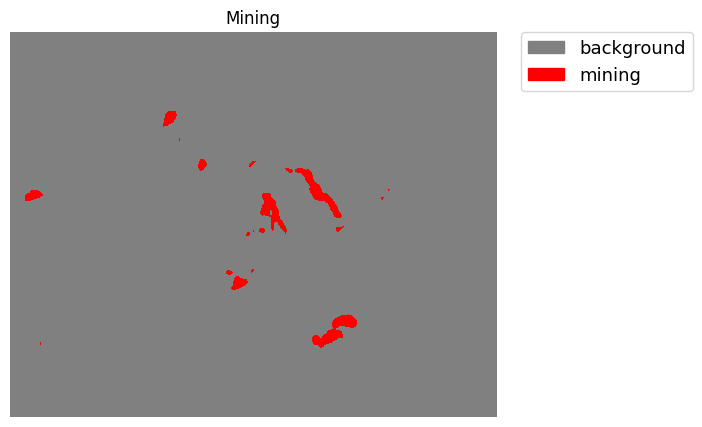

In [133]:
classes = list(np.unique(predicted_classes_arr).astype('int'))
class_colors = ['gray', 'red']
class_names = ['background', 'mining']
class_boundaries = BoundaryNorm([-.5, .5, 1.5], 2)

color_map = ListedColormap(class_colors)
figure, axis = plt.subplots(figsize=(10,5))
im = axis.imshow(predicted_classes_arr, cmap = color_map, norm=class_boundaries)
axis.set(title="Mining")
ep.draw_legend(im, titles = class_names, classes = classes)
axis.set_axis_off()
plt.show()